In [25]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

import numpy as np
from sklearn.preprocessing import normalize

# First principles molgen

Molecules are low noise, and the number of rules governing bonds are both well characterised and reasonably simple to code. 

Thus, deep NN solutions may not be necessary for generating isomers of 7 carbons and 2 oxygens. The below shows how you can trivially create new molecules with high success rate. 

Currently lacks the ability to tell when there's still two separated molecules (might be fixed by a oneliner in networkx?) 


Some adjustments include:
* choosing a bond based on nearness (i.e. it's less common to bond to a carbon that's only 2 bonds away).
* choosing preference for bonding to oxygen vs carbon. 
* Monte Carlo sampling of bond space based on minimized energy


In [283]:
from rdkit.Chem.rdmolops import GetMolFrags

In [48]:
def get_proto_mol(atomicNumList=[6, 6, 6, 6, 6, 6, 6, 8, 8]):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    #mol = rwMol.GetMol()
    #return mol
    return rwMol

In [292]:
def get_bond_graph(mol):
    a_mat = np.zeros([mol.GetNumAtoms(), mol.GetNumAtoms()])
    for i in mol.GetBonds():
        a_mat[i.GetBeginAtomIdx()][i.GetEndAtomIdx()]=1
        a_mat[i.GetEndAtomIdx()][i.GetBeginAtomIdx()]=1
    
    return(a_mat)


def make_mol():
    mol = get_proto_mol()
    potential_bonds = np.array([4, 4, 4, 4, 4, 4, 4, 2, 2])

    a_mat = get_bond_graph(mol)
    num_bonds = np.sum(a_mat, axis=0)
    #for _ in range(10):
    while np.min(num_bonds)<1 or len(GetMolFrags(mol))>1:
        j, k = np.random.choice( ((potential_bonds-num_bonds)>0).nonzero()[0], 2, replace=False)
        if a_mat[j][k]==0:
            mol.AddBond(int(j), int(k))
            a_mat = get_bond_graph(mol)
        num_bonds = np.sum(a_mat, axis=0)
        
    return mol.GetMol()

In [295]:
molList = list()
for _ in range(20):
    molList.append(make_mol())

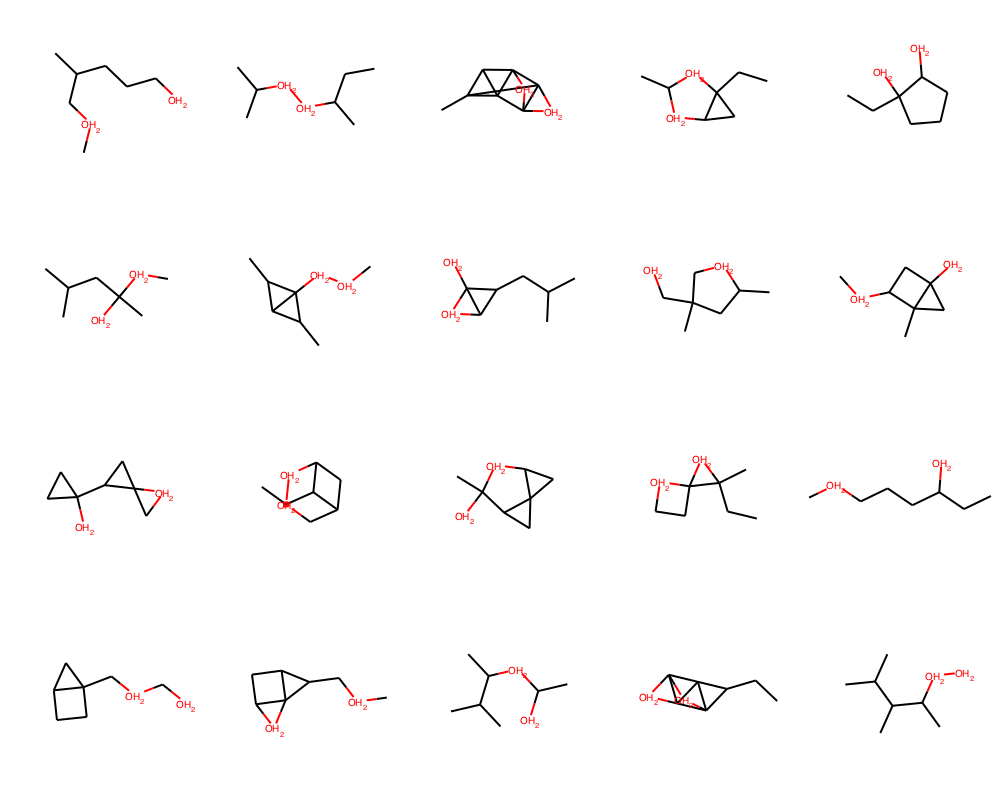

In [296]:
Draw.MolsToGridImage(molList, molsPerRow=5)